In [2]:
%matplotlib inline


# Transform EEG data using current source density (CSD)

This script shows an example of how to use CSD [1]_ [2]_ [3]_.
CSD takes the spatial Laplacian of the sensor signal (derivative in both
x and y). It does what a planar gradiometer does in MEG. Computing these
spatial derivatives reduces point spread. CSD transformed data have a sharper
or more distinct topography, reducing the negative impact of volume conduction.


In [11]:
# Authors: Alex Rockhill <aprockhill206@gmail.com>
#
# License: BSD (3-clause)


import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import inspect


import mne
from mne.datasets import sample

print(__doc__)

data_path = sample.data_path()
print(data_path)

print(matplotlib.__version__)

Automatically created module for IPython interactive environment
/Users/jose/mne_data/MNE-sample-data
3.2.2


Load sample subject data



In [3]:
raw = mne.io.read_raw_fif(data_path + '/MEG/sample/sample_audvis_raw.fif',
                          preload=True)
events = mne.find_events(raw)
raw = raw.pick_types(meg=False, eeg=True, eog=True, ecg=True, stim=False,
                     exclude=raw.info['bads'])
raw.set_eeg_reference(projection=True).apply_proj()

Opening raw data file /Users/jose/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Current compensation grade : 0
Reading 0 ... 166799  =      0.000 ...   277.714 secs...
320 events found
Event IDs: [ 1  2  3  4  5 32]
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
4 projection items activated
SSP projectors applied...


<Raw | sample_audvis_raw.fif, 60 x 166800 (277.7 s), ~79.4 MB, data loaded>

Plot the raw data and CSD-transformed raw data:



Fitted sphere radius:         91.0 mm
Origin head coordinates:      -4.1 16.0 51.7 mm
Origin device coordinates:    1.4 17.8 -10.3 mm


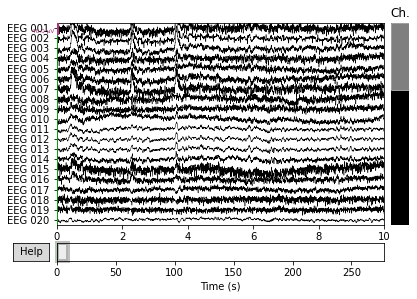

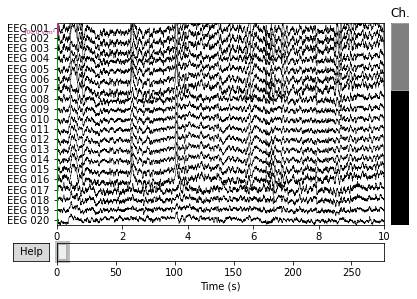

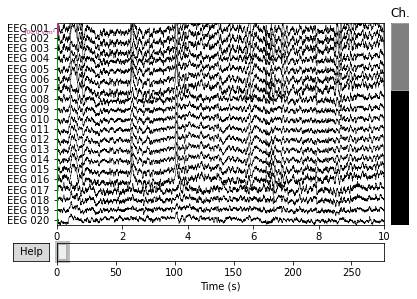

In [4]:
raw_csd = mne.preprocessing.compute_current_source_density(raw)
raw.plot()
raw_csd.plot()

Also look at the power spectral densities:



Effective window size : 3.410 (s)


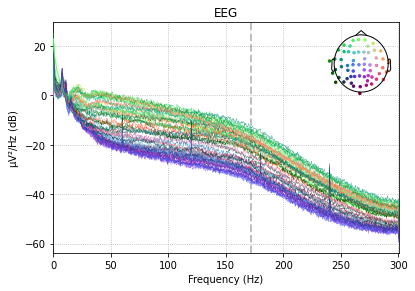

Effective window size : 3.410 (s)


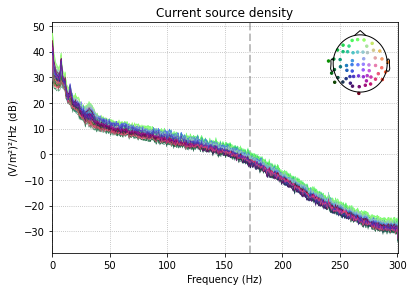

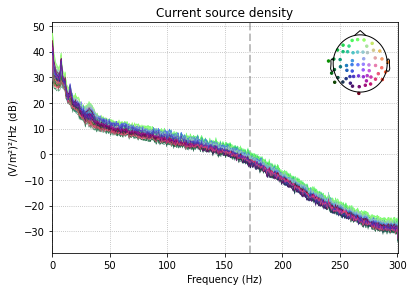

In [15]:

f = raw.plot_psd()
raw_csd.plot_psd()

CSD can also be computed on Evoked (averaged) data.
Here we epoch and average the data so we can demonstrate that.



In [16]:
event_id = {'auditory/left': 1, 'auditory/right': 2, 'visual/left': 3,
            'visual/right': 4, 'smiley': 5, 'button': 32}
epochs = mne.Epochs(raw, events, event_id=event_id, tmin=-0.2, tmax=.5,
                    preload=True)
evoked = epochs['auditory'].average()

320 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 1)
4 projection items activated
Loading data for 320 events and 421 original time points ...
0 bad epochs dropped


First let's look at how CSD affects scalp topography:



Fitted sphere radius:         91.0 mm
Origin head coordinates:      -4.1 16.0 51.7 mm
Origin device coordinates:    1.4 17.8 -10.3 mm


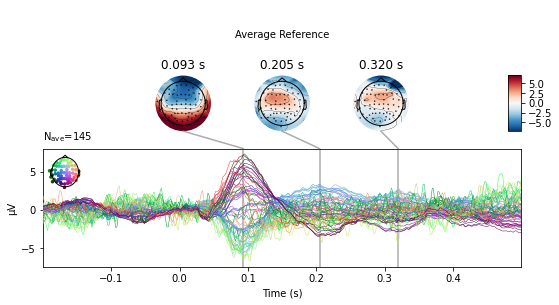

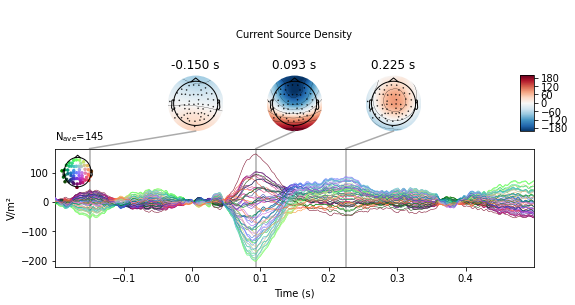

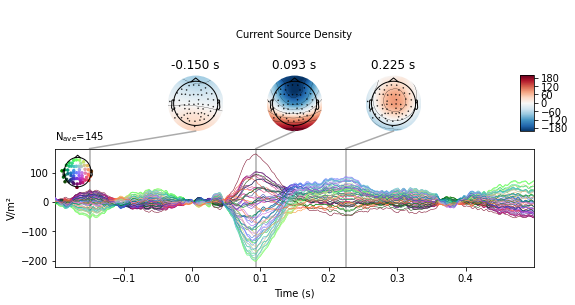

In [7]:
times = np.array([-0.1, 0., 0.05, 0.1, 0.15])
evoked_csd = mne.preprocessing.compute_current_source_density(evoked)
evoked.plot_joint(title='Average Reference', show=False)
evoked_csd.plot_joint(title='Current Source Density')

CSD has parameters ``stiffness`` and ``lambda2`` affecting smoothing and
spline flexibility, respectively. Let's see how they affect the solution:



In [ ]:
fig, ax = plt.subplots(4, 4)
fig.subplots_adjust(hspace=0.5)
fig.set_size_inches(10, 10)
for i, lambda2 in enumerate([0, 1e-7, 1e-5, 1e-3]):
    for j, m in enumerate([5, 4, 3, 2]):
        this_evoked_csd = mne.preprocessing.compute_current_source_density(
            evoked, stiffness=m, lambda2=lambda2)
        this_evoked_csd.plot_topomap(
            0.1, axes=ax[i, j], outlines='skirt', contours=4, time_unit='s',
            colorbar=False, show=False)
        ax[i, j].set_title('stiffness=%i\nλ²=%s' % (m, lambda2))

## References
.. [1] Perrin F, Bertrand O, Pernier J. "Scalp current density mapping:
       Value and estimation from potential data." IEEE Trans Biomed Eng.
       1987;34(4):283–288.
.. [2] Perrin F, Pernier J, Bertrand O, Echallier JF. "Spherical splines
       for scalp potential and current density mapping."
       [Corrigenda EEG 02274, EEG Clin. Neurophysiol., 1990, 76, 565]
       Electroenceph Clin Neurophysiol. 1989;72(2):184–187.
.. [3] Kayser J, Tenke CE. "On the benefits of using surface Laplacian
      (Current Source Density) methodology in electrophysiology.
      Int J Psychophysiol. 2015 Sep; 97(3): 171–173.

